# Radiology Image Classification

#### Import the required libraries

In [147]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import PIL
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.losses import BinaryCrossentropy
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#### Import the datasets and label metadata

In [149]:
# Import the dataset
training_dir = "C:/Users/mming/OneDrive/Desktop/Chest-Classification"
# Windows PWD: C:/Users/mming/OneDrive/Desktop/Chest-Classification
# OSX PWD: /Users/markmingo/Desktop/MURA-v1.1/train

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32

VALIDATION_TEST_SPLIT = 690

# Create training set
ds_train = keras.utils.image_dataset_from_directory(
    training_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE),
    seed=123,
    validation_split=0.2,
    subset="training"
)

# Create cross-validation set
ds_validation = keras.utils.image_dataset_from_directory(
    training_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE),
    seed=123,
    validation_split=0.2,
    subset="validation"
)

# Create test set from cross-validation allocation
ds_test = ds_validation.take(VALIDATION_TEST_SPLIT)
ds_validation = ds_validation.skip(VALIDATION_TEST_SPLIT)

print(len(ds_test))
print(len(ds_validation))

# Class names
class_names = ds_train.class_names
print(class_names)

Found 6902 files belonging to 3 classes.
Using 5522 files for training.
Found 6902 files belonging to 3 classes.
Using 1380 files for validation.
44
0
['covid', 'normal', 'pneumonia']


#### Display specific image(s) 

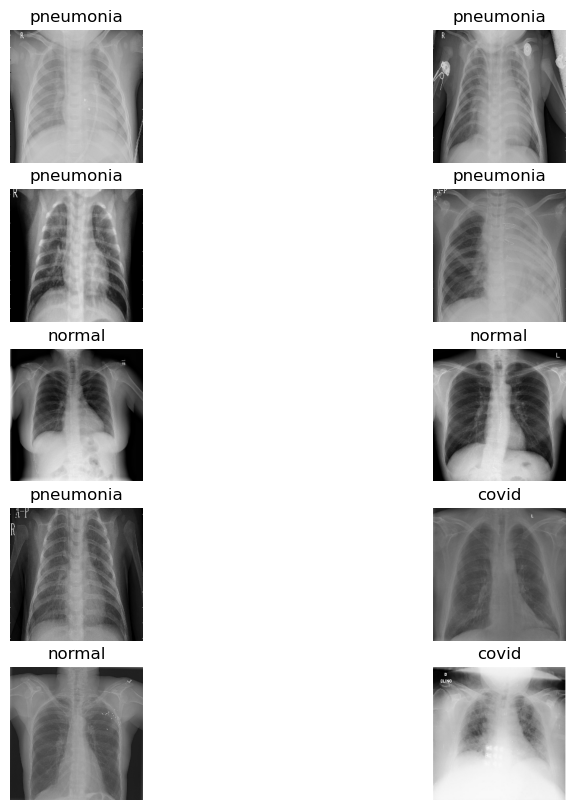

In [103]:
# Visualize the data
plt.figure(figsize=(10, 10))
image, label = next(iter(ds_train))
for images, labels in ds_train.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

#### Add data augmentation

In [131]:
data_augmentation = Sequential([
    layers.RandomZoom(-0.1, -0.25),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

#### Configure dataset's for performance

In [133]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_validation = ds_validation.prefetch(buffer_size=AUTOTUNE)

#### Display an image with data augmentation

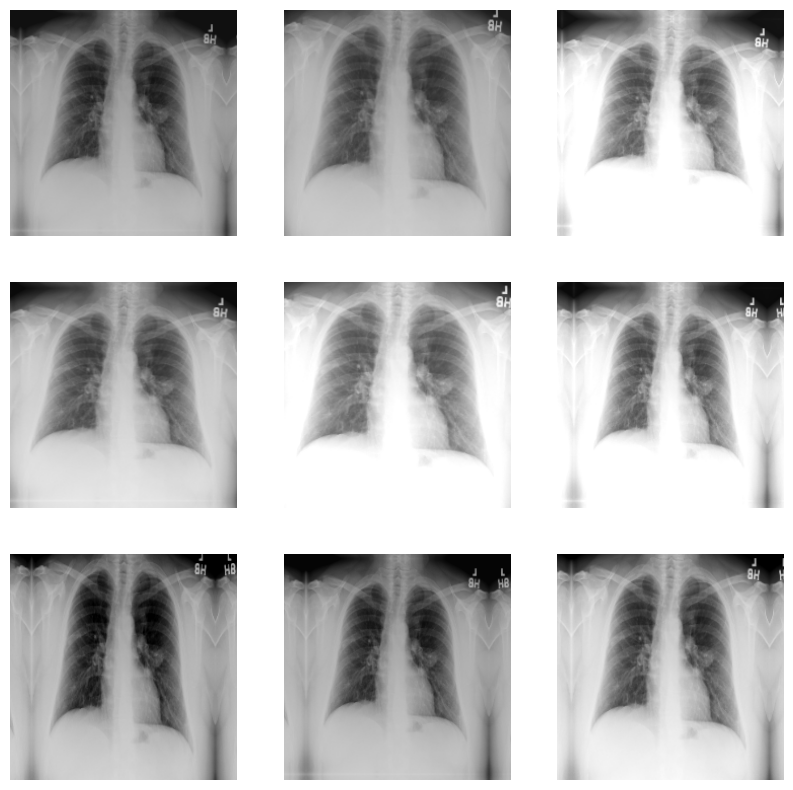

In [139]:
plt.figure(figsize=(10, 10))
for images, _ in ds_train.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype('uint8'))
        plt.axis('off')

### Convert images from RBG to BGR and zero-center each color channel.

###### Reguired for ResNet50 with ImageNet transfer learning.

In [150]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

#### Create the model

In [151]:
IMG_SHAPE = IMG_SIZE + (3,)

model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)


94765736/94765736 [==============================] - 3s 0us/step


#### Freeze layers for feature extraction

In [152]:
model.trainable = False

In [153]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       